Symbolic nonsense

In [ ]:
a, b, c, d, x, y, z, = sp.symbols('a b c d x y z')

simple_tilt = a * x * sp.exp(-b * x**2)

simple_tilt_first_derivative = sp.diff(simple_tilt, x)
simple_tilt_third_derivative = sp.diff(simple_tilt, x, 3)

s0_1 = sp.powsimp(simple_tilt_first_derivative.evalf(subs={x: 0}))
s0_3 = simple_tilt_third_derivative.evalf(subs={x: 0})

mogi_tilt = sp.atan2(3 * d * x, c * (d**2 + x**2)**2.5 + (d**2 - 2*x**2))

mogi_tilt_first_derivative = sp.diff(mogi_tilt, x)
mogi_tilt_third_derivative = sp.diff(mogi_tilt, x, 3)

m0_1 = mogi_tilt_first_derivative.evalf(subs={x: 0})
m0_1 = (3 * d / c * d**5 + d**2)  # manual simplification

m0_3 = mogi_tilt_third_derivative.evalf(subs={x: 0})

# m0_3 = sp.simplify(3 * d * (4 - 5 * c * d**3 + (-18 * d**2 - (10 * c * d**3 - 8) * (c * d**5 + d**2)) / (c * d**5 + d**2)) / (c*d**5 + d**2) ** 2) # more simplification

# m0_3.evalf(subs={c: 0.016384, d: 3.7})

def simplify_tilt_function(c_val, d_val):
    a = m0_1.evalf(subs={c: c_val, d: d_val})
    b_exp = -m0_3 / (6 * a)
    b = b_exp.evalf(subs={c: c_val, d: d_val})
    return a, b

def inverse_model(a_val, b_val):
    pass

c_val = 2.4615384615*10**-13

a, b = simplify_tilt_function(c_val=c_val, d_val=15000)
a, b

In [ ]:
def map_data_from_csv(feature, num) -> pd.DataFrame:
    '''read GIS attribute table exports'''
    return pd.read_csv(f"{map_path}{feature}_{str(num)}.csv")

flow_filenames = glob.glob(map_path + "flow*.csv")
channel_filenames = glob.glob(map_path + "channel*.csv")

@dataclass
class Center:
    cID: int
    pop: Population

    def __post_init__(self):

        # read data and take subset if passed
        self.data = map_data_from_csv(self.pop.feature, self.cID)
        if self.pop.sIDs is not None:
            self.data = self.data.loc[self.data['ORIG_FID'].isin(self.pop.sIDs)]

        # calculate beta1 for summit score. I know this is ridiculous
        self.data['BETA1'] = self.data.apply(
            lambda row:
                deg(arccos(cos(rad(row['AZ1'] - row['THETA'])))), axis=1
        )

        # define a criterion for realistic tilt. TODO: make f(dist)
        MAX_TILT = 5

        def inflation_is_realistic(df) -> list:
            return abs(df['TILT']) < MAX_TILT

        self.data_realistic_inflation = self.data[inflation_is_realistic(
            self.data)]

        # correct distances to km and add other key attributes to object
        self.dist = self.data['DIST'] / 1000
        self.tilt = self.data['TILT']
        self.beta1 = self.data['BETA1']

        # correct distances to km and add other key attributes to object
        self.dist_realistic = self.data_realistic_inflation['DIST'] / 1000
        self.tilt_realistic = self.data_realistic_inflation['TILT']

        self.evaluate()

    def evaluate(self):
        self.full_name = f'{self.pop.feature}_{self.pop.name}'
        self.criteria = {
            'ID': self.cID,
            f'frac_possible_{self.full_name}':
                self.data['TILT'].notnull().sum() / len(self.data),
            f'frac_realistic_{self.full_name}':
                self.data_realistic_inflation['TILT'].notnull(
                ).sum() / len(self.data),
            f'summit_score_{self.full_name}':
                mean(abs(self.data['BETA1'])),
        }

So this ended up being useless but I'll leave it in. I should have just ran the model in flat vs topo conditions and compared, rather than try to justify using the flat equation to construct tilt from the topo model results, just very silly overall... (everything below here)

This cell is used to test the hypothesis that modelled tilt will be insensitive (for my purposes) to previous topography. This is a key assumption without which it is not possible to proceed with testing candidate inflation centers at different locations.

In [1]:
# read .csv
from svglib.svglib import svg2rlg

# computation & data structures
import numpy as np
from math import *
import itertools
import pandas as pd
import glob

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.graphics import renderPDF
import os
import shutil
from dataclasses import dataclass

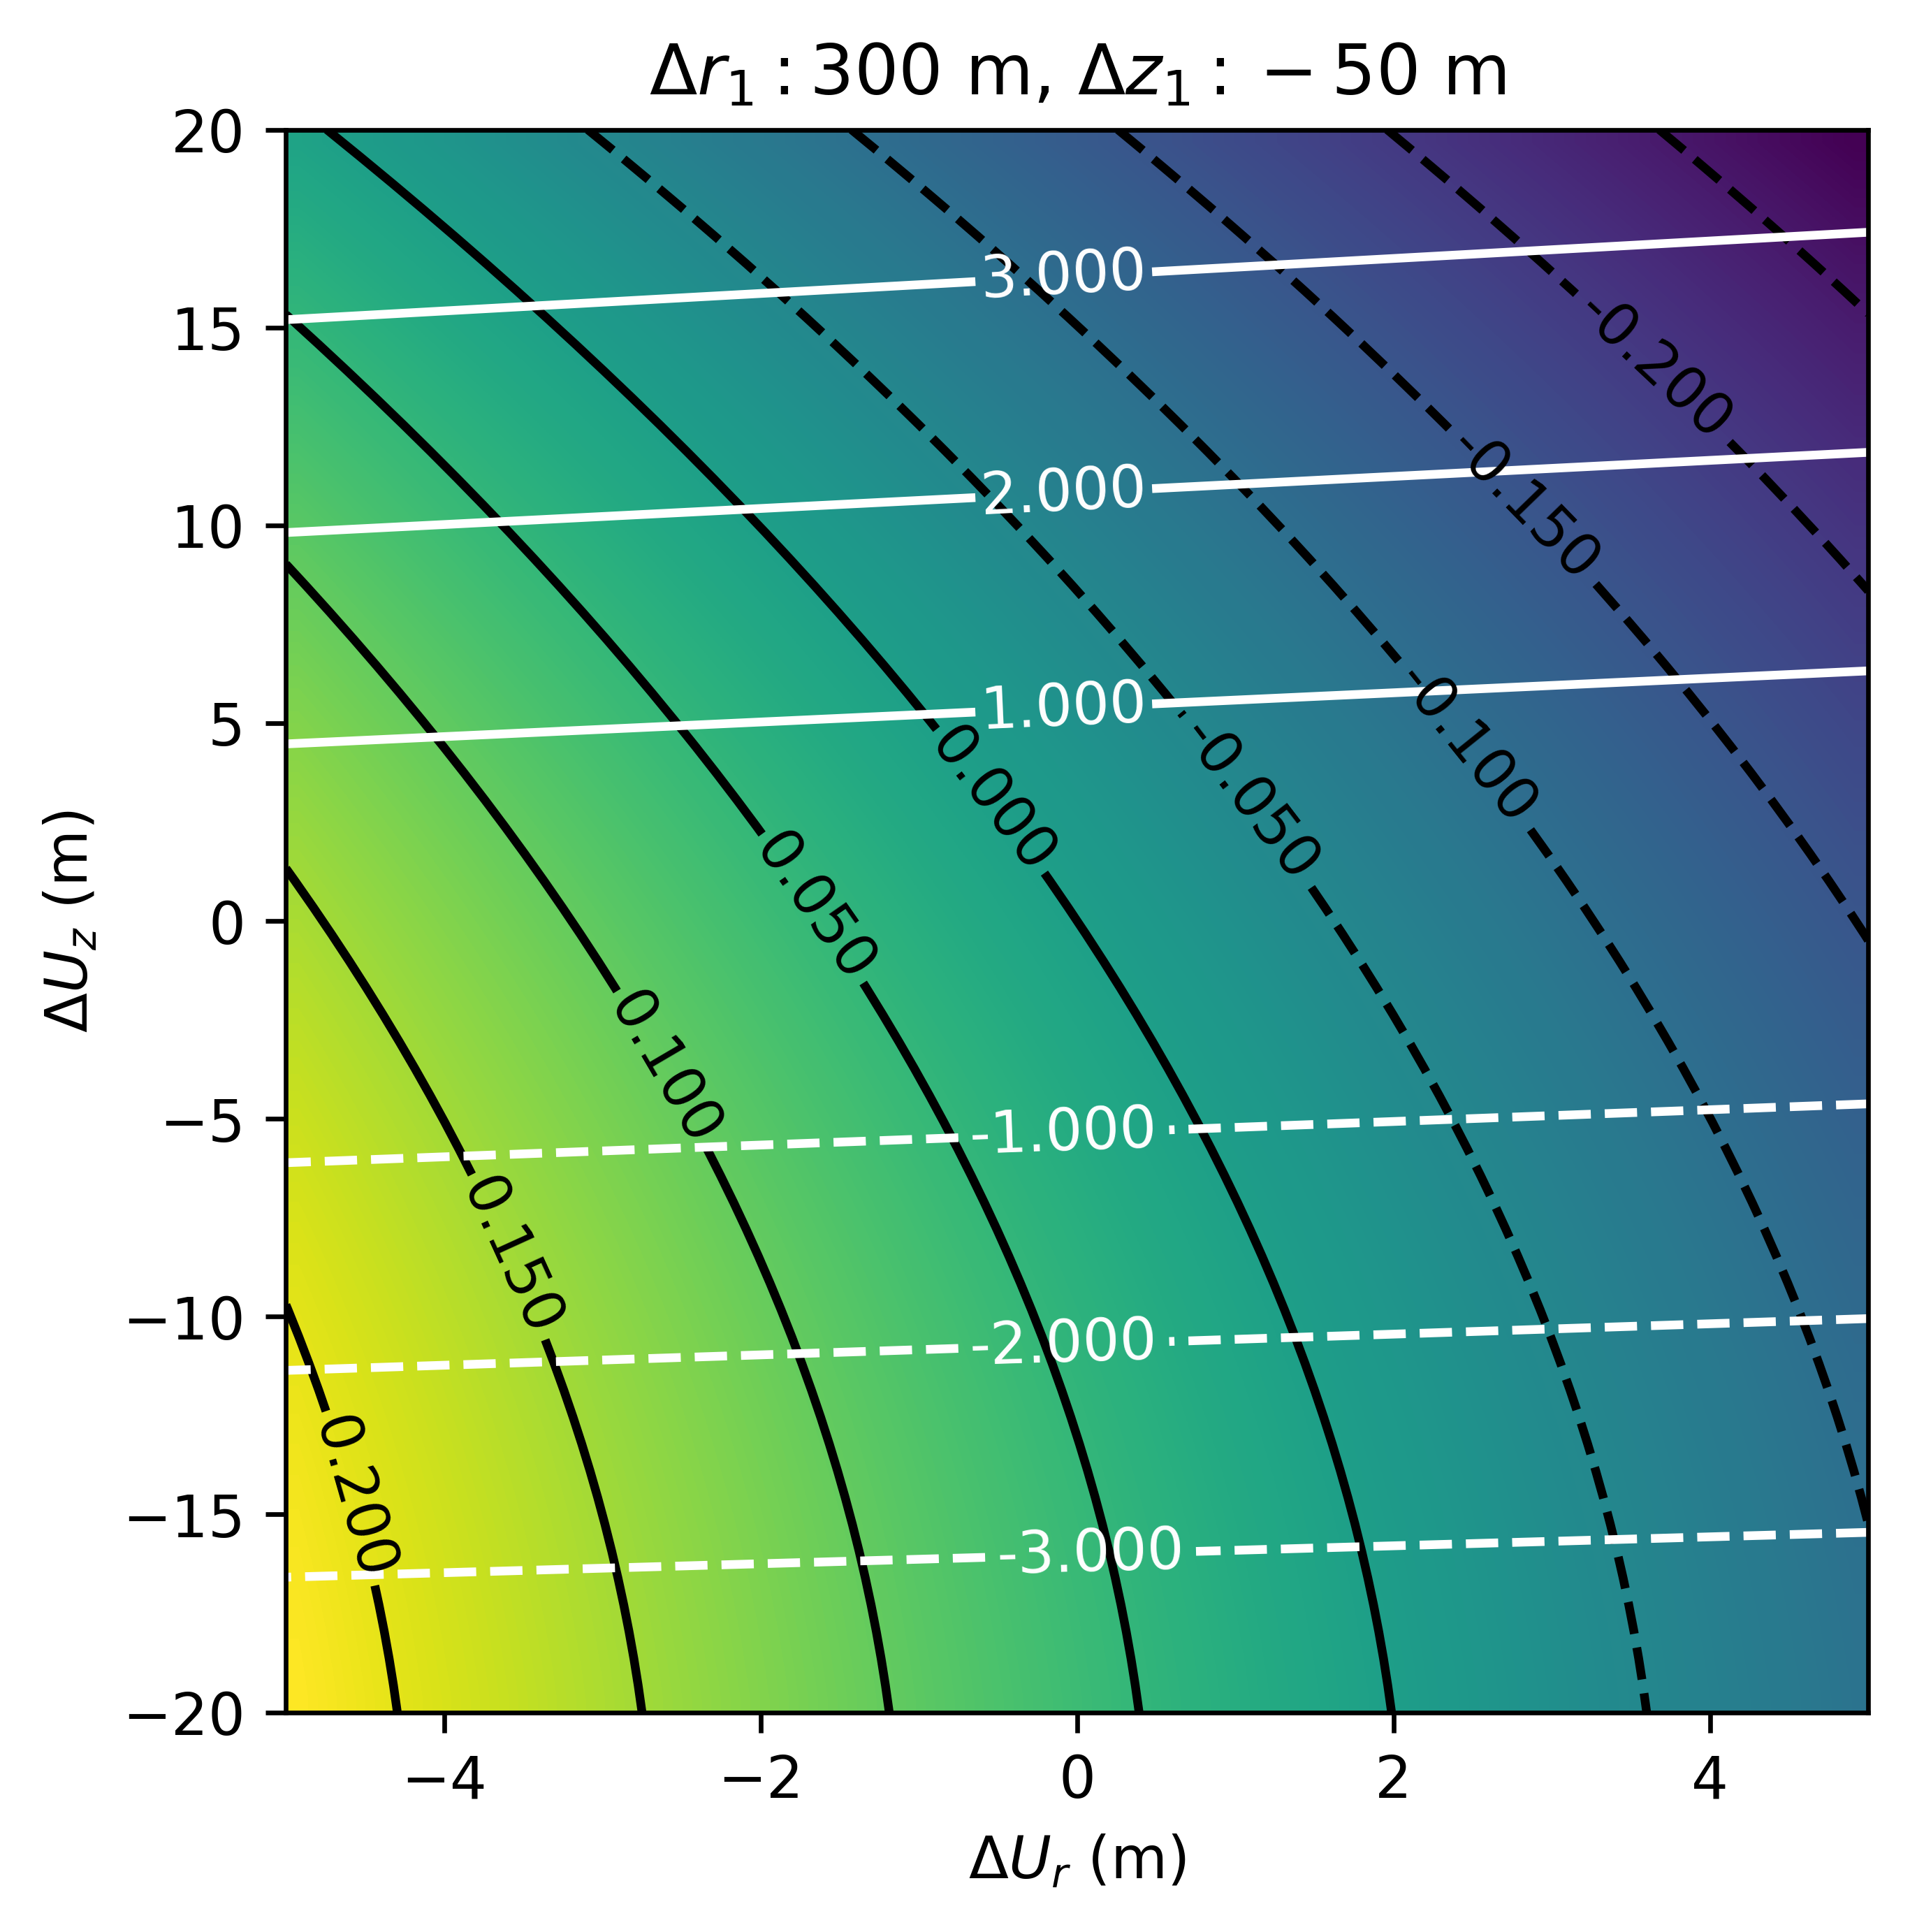

In [2]:
dz1 = -50
dr1 = 300
dUz = -20
dUr = 5

dz1_range = (-50, 50)
dr1_range = (100, 800)
dUz_range = (-20, 20)
dUr_range = (-5, 5)


def flat_model_error(dz1, dr1, dUz, dUr):
    tilt = np.arctan2(dz1, dr1) - np.arctan2((dz1 + dUz), (dr1 + dUr))
    flat_tilt = -np.arctan2(dUz, (dr1 + dUr))
    error = np.degrees(tilt - flat_tilt)
    return error

def tilt(dz1, dr1, dUz, dUr):
    tilt = np.arctan2(dz1, dr1) - np.arctan2((dz1 + dUz), (dr1 + dUr))
    return np.degrees(tilt)

# use x = r and y = r

resolution = 60

# fixed dz1, dr1
# variable dUz, dUr:

xs = np.linspace(*dUr_range, num=resolution)
ys = np.linspace(*dUz_range, num=resolution)

X, Y = np.meshgrid(xs, ys)

z = np.array([flat_model_error(dz1, dr1, y, x) for y in ys for x in xs]).reshape(resolution, resolution)

fig = plt.figure(figsize = (5,5), dpi = 600)

plt.xlabel('$\Delta U_r$ (m)')
plt.ylabel('$\Delta U_z$ (m)')
plt.title(f'$\Delta r_1: {dr1}$ m, $\Delta z_1: {dz1}$ m')

extent = xs[0], xs[-1], ys[0], ys[-1]

contours = plt.contour(X, -Y, flat_model_error(dz1, dr1, Y, X), 10, colors='black')
contours_tilt = plt.contour(X, -Y, tilt(dz1, dr1, Y, X), levels=[-3, -2, -1, 1, 2, 3], colors='white')

plt.clabel(contours_tilt, inline=1, fontsize=10)
plt.clabel(contours, inline=1, fontsize=10)

plt.imshow(z, interpolation='bilinear', extent=extent, aspect=1/4)

the actual magnitude of tilt is most sensitive to $\Delta U_z$, but the error introduced by the flat approximation is most sensitive to $\Delta U_r$.

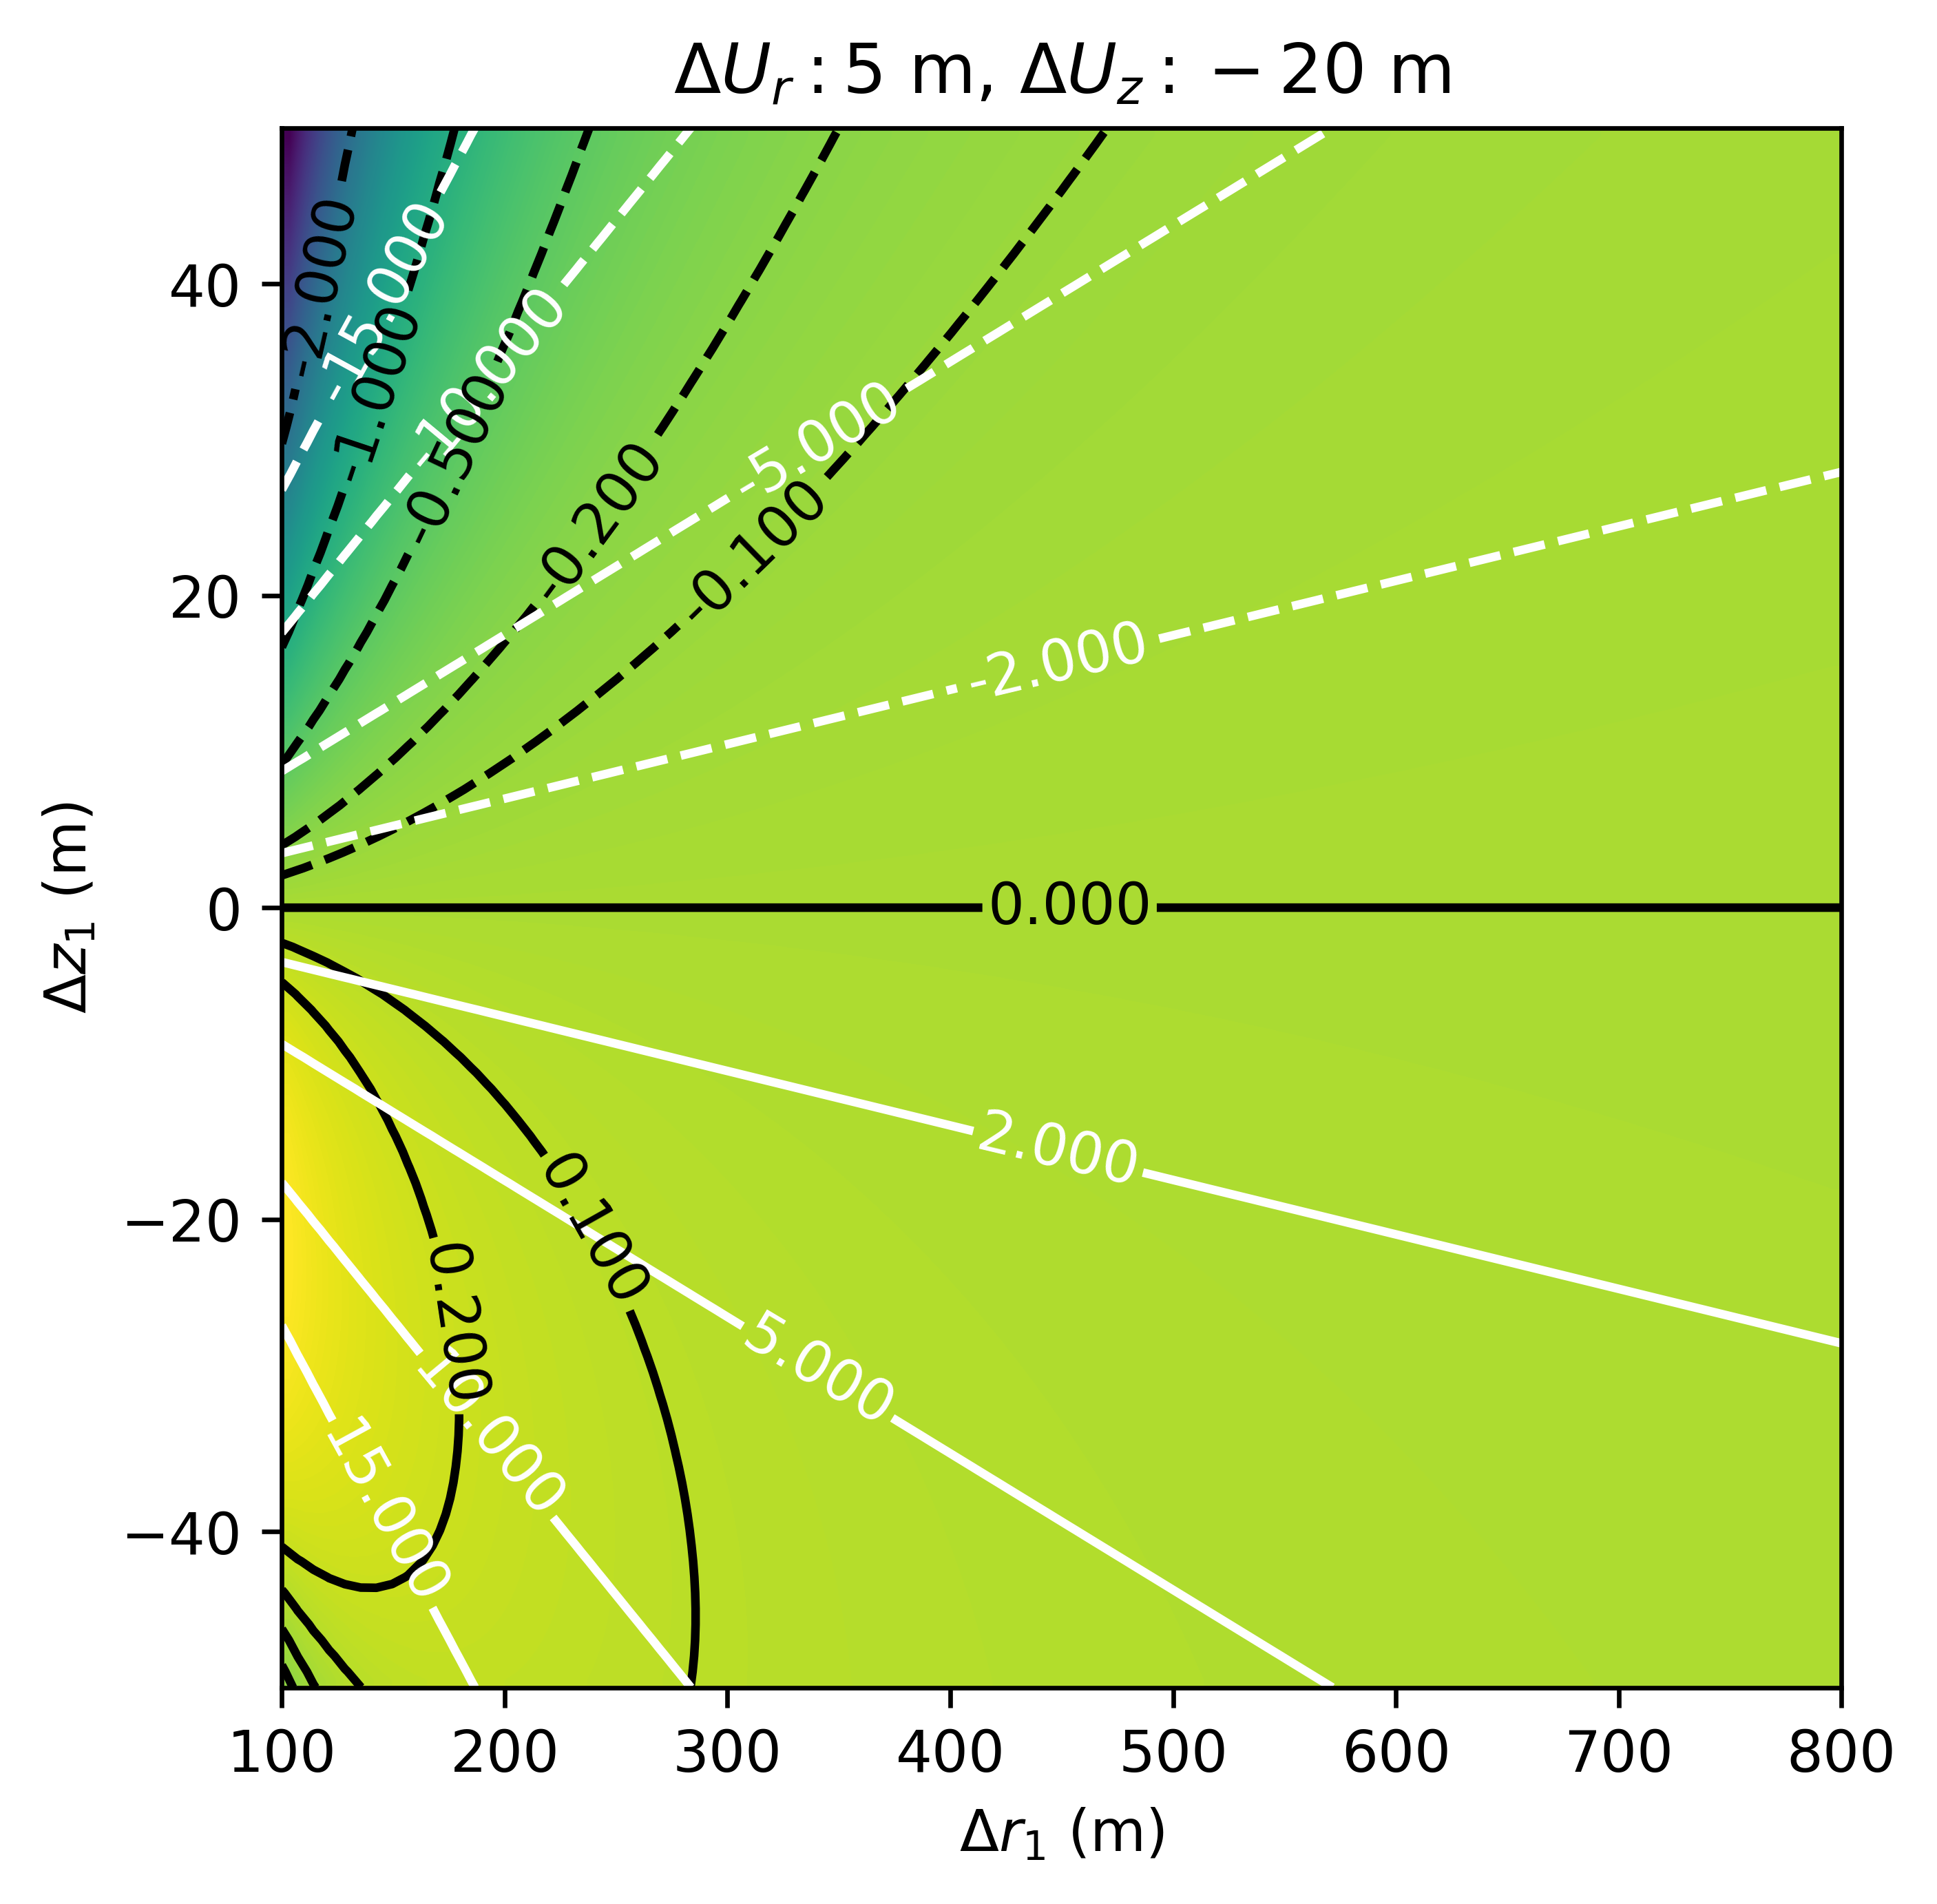

In [3]:
resolution = 100

# fixed dUr, dUz
# varaible dr1, dz1:

xs = np.linspace(*dr1_range, resolution)
ys = np.linspace(*dz1_range, resolution)

X, Y = np.meshgrid(xs, ys)

z = np.array([flat_model_error(y, x, dUz, dUr) for y in ys for x in xs]).reshape(resolution, resolution)

fig = plt.figure(figsize = (5,5), dpi = 600)

plt.xlabel('$\Delta r_1$ (m)')
plt.ylabel('$\Delta z_1$ (m)')
plt.title(f'$\Delta U_r: {dUr}$ m, $\Delta U_z: {dUz}$ m')

extent = xs[0], xs[-1], ys[0], ys[-1]

contours = plt.contour(X, -Y, flat_model_error(Y, X, dUz, dUr), levels=[-2,-1, -0.5, -0.2, -0.1, 0, 0.1, 0.2], colors='black')
contours_slope = plt.contour(X, -Y, np.degrees(np.arctan2(Y,X)), levels=[-15,-10,-5,-2,2,5,10,15], colors='white')

plt.clabel(contours_slope, inline=1, fontsize=10)
plt.clabel(contours, inline=1, fontsize=10)

plt.imshow(z, interpolation='bilinear', extent=extent, aspect=7)

A few things to note in this second plot. First obviously the closer the slope is to zero, the better the flat approximation is. It's only once the initial slope is on the order of 10 degrees that even a single degree of tilt error is introduced by the flat approximation. 